<a href="https://colab.research.google.com/github/Paymanshus/ML-Sem-V/blob/master/ML_J046_Lab13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised learning using machine learning models

## Objectives
- Use Auto encoder on CIFAR10
- Perform clustering on Airqualityindex. Identify best clustering technique on the dataset.

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

!pip install livelossplot
from livelossplot import PlotLossesKeras

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

170500096/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 1) (10000, 1)


In [3]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = x_train[:,:,:,0]
x_test = x_test[:,:,:,0]

In [4]:
print('Training Shape:', x_train.shape)
print('Number of train samples:', x_train.shape[0])
print('Number of test samples:', x_test.shape[0])

Training Shape: (50000, 32, 32)
Number of train samples: 50000
Number of test samples: 10000


In [5]:
x_val = x_test[:7000]
x_test = x_test[7000:]
print("Validation Data Shape: {0} \nTest Data Shape: {1}".format(x_val.shape, x_test.shape))

Validation Data Shape: (7000, 32, 32) 
Test Data Shape: (3000, 32, 32)


In [6]:
input_img = Input(shape=(32, 32))

#Encoding
x = Dense(128, activation = 'relu')(input_img)
x = Dense(64, activation = 'relu')(x)
x = Dense(32, activation = 'relu')(x)
x = Dense(16, activation = 'relu')(x)
encoded = Dense(8, activation = 'relu')(x)

# Decoding
x = Dense(8, activation = 'relu')(encoded)
x = Dense(16, activation = 'relu')(x)
x = Dense(32, activation = 'relu')(x)
x = Dense(64, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
decoded = Dense(32, activation = 'sigmoid')(x)

In [7]:
model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='binary_crossentropy')

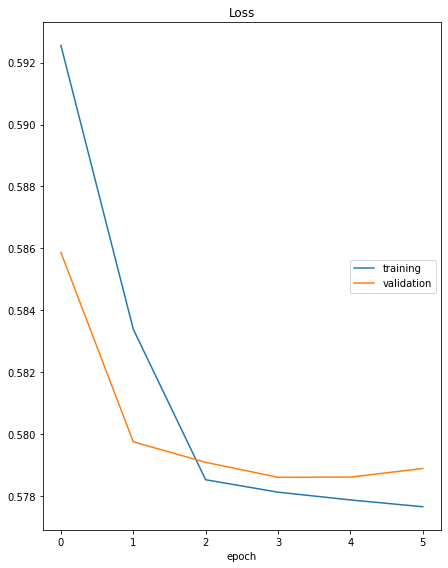

Loss
	training         	 (min:    0.578, max:    0.593, cur:    0.578)
	validation       	 (min:    0.579, max:    0.586, cur:    0.579)
1563/1563 [==============================] - 19s 12ms/step - loss: 0.5777 - val_loss: 0.5789
Epoch 00006: early stopping


In [8]:
batch_size = 32
num_classes = 10
epochs = 100
es = EarlyStopping(monitor = 'val_loss', patience = 2, verbose = 1, mode = 'auto')
chkpt = 'AutoEncoder_Cifar10_Deep_weights.hdf5'
mc = ModelCheckpoint(filepath = chkpt, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'auto')

history = model.fit(x_train, x_train, batch_size = batch_size, epochs = epochs, verbose = 1, validation_data = (x_val, x_val), 
                    callbacks = [es, mc, PlotLossesKeras()], shuffle = True)

In [9]:
score = model.evaluate(x_test, x_test, verbose=1)
print(score)

94/94 [==============================] - 0s 5ms/step - loss: 0.5784
0.5784212350845337


In [10]:
c10test = model.predict(x_test)
c10val = model.predict(x_val)
print("Validation Dataset Score: {0}\nTest Dataset Score: {1}".format(np.average(c10val), np.average(c10test)))

Validation Dataset Score: 0.4839465320110321
Test Dataset Score: 0.47894540429115295


In [11]:
def showOrigDec(orig, dec, num=10):
  n = num 
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # display original
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(orig[i].reshape(32,32))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(dec[i].reshape(32,32))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

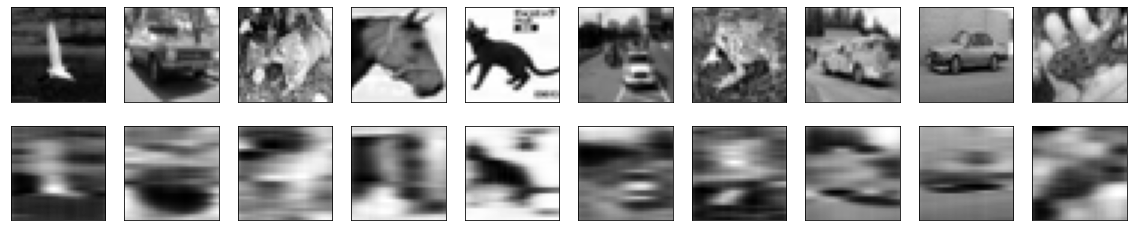

In [12]:
showOrigDec(x_test, c10test)

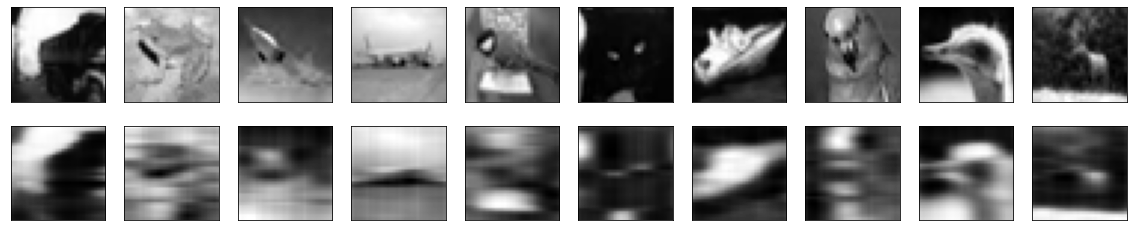

In [13]:
showOrigDec(x_test[100:], c10test[100:])

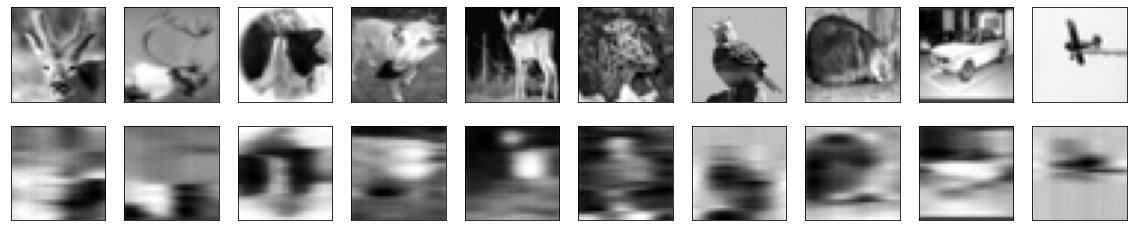

In [14]:
showOrigDec(x_test[200:], c10test[200:])

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering, SpectralClustering, Birch

In [16]:
!wget -O AirQualityUCI.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip
!unzip AirQualityUCI.zip
data = pd.read_excel('/content/AirQualityUCI.xlsx')

--2020-11-03 22:32:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1543989 (1.5M) [application/x-httpd-php]
Saving to: ‘AirQualityUCI.zip’

AirQualityUCI.zip   100%[===================>]   1.47M  4.86MB/s    in 0.3s    

2020-11-03 22:32:05 (4.86 MB/s) - ‘AirQualityUCI.zip’ saved [1543989/1543989]

Archive:  AirQualityUCI.zip
  inflating: AirQualityUCI.csv       
  inflating: AirQualityUCI.xlsx      


In [17]:
data.shape

(9357, 15)

In [18]:
data.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.869652,-159.090093,1.865576,894.475963,168.604200,794.872333,58.135898,1391.363266,974.951534,9.776600,39.483611,-6.837604
std,77.657170,329.817015,139.789093,41.380154,342.315902,257.424561,321.977031,126.931428,467.192382,456.922728,43.203438,51.215645,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.004958,711.000000,50.000000,637.000000,53.000000,1184.750000,699.750000,10.950000,34.050000,0.692275
50%,1.500000,1052.500000,-200.000000,7.886653,894.500000,141.000000,794.250000,96.000000,1445.500000,942.000000,17.200000,48.550000,0.976823
75%,2.600000,1221.250000,-200.000000,13.636091,1104.750000,284.200000,960.250000,133.000000,1662.000000,1255.250000,24.075000,61.875000,1.296223
max,11.900000,2039.750000,1189.000000,63.741476,2214.000000,1479.000000,2682.750000,339.700000,2775.000000,2522.750000,44.600000,88.725000,2.231036


In [19]:
data.replace(to_replace = -200, value = np.NaN, inplace = True )
num = data.isnull().sum()
percent = num/data.shape[0]*100
percent

Date              0.000000
Time              0.000000
CO(GT)           17.986534
PT08.S1(CO)       3.911510
NMHC(GT)         90.231912
C6H6(GT)          3.911510
PT08.S2(NMHC)     3.911510
NOx(GT)          17.516298
PT08.S3(NOx)      3.911510
NO2(GT)          17.548360
PT08.S4(NO2)      3.911510
PT08.S5(O3)       3.911510
T                 3.911510
RH                3.911510
AH                3.911510
dtype: float64

In [20]:
data.drop(['NMHC(GT)'], axis = 1, inplace = True)
num = data.isnull().sum()
percent = num/data.shape[0]*100
percent

Date              0.000000
Time              0.000000
CO(GT)           17.986534
PT08.S1(CO)       3.911510
C6H6(GT)          3.911510
PT08.S2(NMHC)     3.911510
NOx(GT)          17.516298
PT08.S3(NOx)      3.911510
NO2(GT)          17.548360
PT08.S4(NO2)      3.911510
PT08.S5(O3)       3.911510
T                 3.911510
RH                3.911510
AH                3.911510
dtype: float64

In [21]:
data["T"] = data.groupby("Date")["T"].transform(lambda x: x.fillna(x.mean()))
data["CO(GT)"] = data.groupby("Date")["CO(GT)"].transform(lambda x: x.fillna(x.mean()))
data["NOx(GT)"] = data.groupby("Date")["NOx(GT)"].transform(lambda x: x.fillna(x.mean()))
data["NO2(GT)"] = data.groupby("Date")["NO2(GT)"].transform(lambda x: x.fillna(x.mean()))

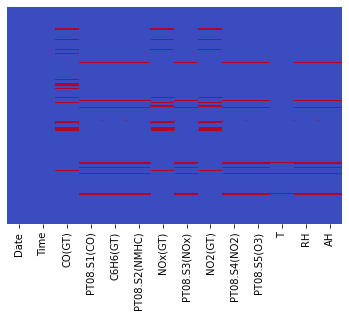

In [22]:
import seaborn as sns

sns.heatmap(data.isnull(), yticklabels = False, cbar = False, cmap = 'coolwarm')

In [23]:
data.fillna(method='ffill', inplace= True)

num = data.isnull().sum()
percent = num/data.shape[0]*100
percent

Date             0.0
Time             0.0
CO(GT)           0.0
PT08.S1(CO)      0.0
C6H6(GT)         0.0
PT08.S2(NMHC)    0.0
NOx(GT)          0.0
PT08.S3(NOx)     0.0
NO2(GT)          0.0
PT08.S4(NO2)     0.0
PT08.S5(O3)      0.0
T                0.0
RH               0.0
AH               0.0
dtype: float64

In [24]:
X1 = data.drop(['Time'], axis=1, inplace=False)
x = X1.drop(['Date'], axis=1, inplace=False)
x.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.6,1360.00,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2.0,1292.25,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2.2,1402.00,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2.2,1375.50,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,1.6,1272.25,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [25]:
birch = Birch()
pred_birch = birch.fit_predict(x)

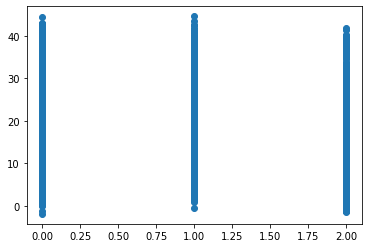

In [26]:
plt.scatter(pred_birch, x['T'], cmap = 'coolwarm')

In [27]:
agg = AgglomerativeClustering(affinity = 'euclidean', compute_full_tree = 'auto', connectivity = None, 
                              distance_threshold = None, linkage = 'ward', memory = None, n_clusters = 3)
pred_agg = agg.fit_predict(x)

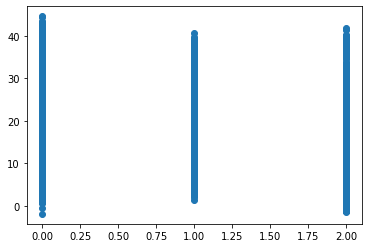

In [28]:
plt.scatter(pred_agg, x['T'], cmap = 'coolwarm')